In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from math import inf
from optical_flow import *
from tqdm import tqdm

seq_path = '../datasets/results_opticalflow_kitti/'

In [2]:
past_img = cv2.imread(seq_path + '000045_10.png')
current_img = cv2.imread(seq_path + '000045_11.png')

optical_flow_path = seq_path +'gt_000045_10_noc.png'
gt_flow = load_flow(optical_flow_path)

In [3]:
optical_flow = block_matching(current_img, past_img, 'backward', 'ncc', 31, 40, 1)

100%|██████████| 13/13 [04:34<00:00, 21.09s/it]


MSNE:  5.92343907086746 PEPN: 24.933384453177418


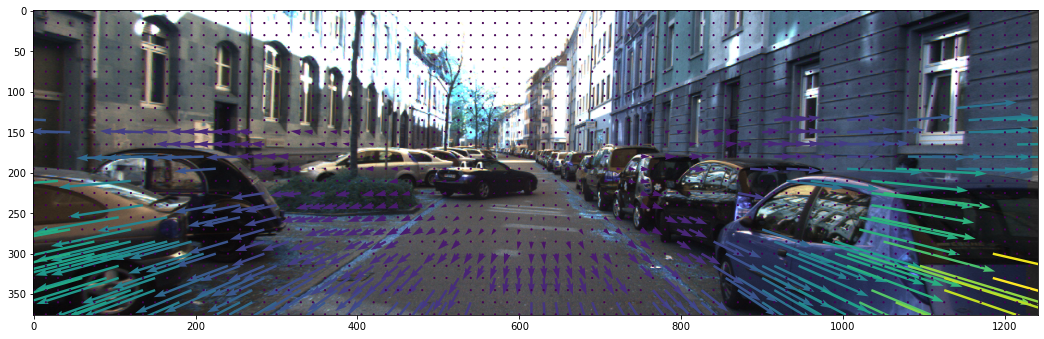

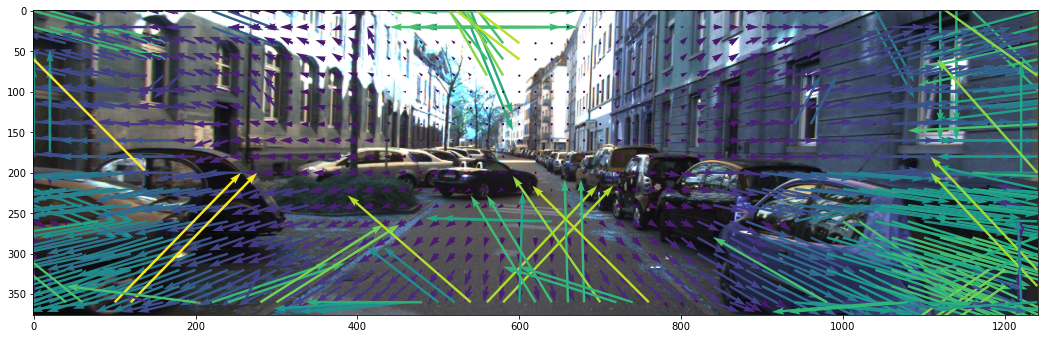

In [4]:
error_msne = flow_msen(gt_flow, optical_flow)
error_pepn = flow_pepn(gt_flow, optical_flow)
print('MSNE: ', error_msne, 'PEPN:', error_pepn)
plot_optical_flow_field(seq_path + '000045_11.png', gt_flow, 15, 0.25)
plot_optical_flow_field(seq_path + '000045_11.png', optical_flow, 20, 0.25)

In [3]:
from load_utils import *
gt_detect = readDetectionsXML('ai_challenge_s03_c010-full_annotation.xml')
gt_notParked = getNotParkedCars(gt_detect)

In [4]:
data_path = '../../AICity_data/train/S03/c010/'
vidcap = cv2.VideoCapture(data_path + 'vdo.avi')
ims = []

for frame in tqdm(range(600)):
    sucess, image = vidcap.read()
    if frame > 597:
        ims.append(image)

100%|██████████| 600/600 [00:08<00:00, 74.65it/s]


In [10]:
optical_flow2 = block_matching(ims[1], ims[0], 'backward', 'ssd', 32, 32, 2)

100%|██████████| 34/34 [03:37<00:00,  6.39s/it]


In [11]:
# plot optical flow
def plot_optical_flow_field2(img, flow, step=20, scale=0.1):
    plt.figure(figsize=(18,6))
    plt.imshow(img)

    h, w = flow[0].shape

    X = np.arange(0, w, step)
    Y = np.arange(0, h, step)
    U, V = np.meshgrid(X, Y)

    u_flow = flow[0][::step, ::step]
    v_flow = flow[1][::step, ::step]

    plt.quiver(U, V, u_flow, v_flow, np.hypot(u_flow, v_flow),scale_units='xy', angles='xy', scale=scale)
    plt.show()

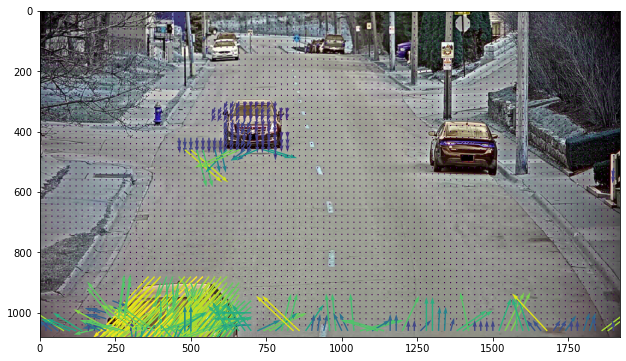

In [12]:
plot_optical_flow_field2(ims[1], optical_flow2, 20, 0.25)

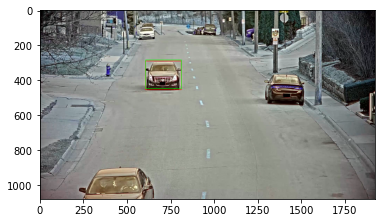

In [14]:
import copy
imgCopy = copy.deepcopy(ims[1])
P = 50
N = 32
box = (gt_notParked['598'][1].getBBox())
block = ims[0][int(box[1]):int(box[3]), int(box[0]):int(box[2])]
imgCopy = cv2.rectangle(imgCopy, (int(box[0]),int(box[1])), (int(box[2]),int(box[3])), (255,0,0), 2)
blocH_size = block.shape[0]
blocW_size = block.shape[1]                
area_minx = max(0, int(box[0]) - P)
area_miny = max(0, int(box[1]) - P)
area_maxX = min(ims[1].shape[1] - blocW_size, int(box[2]) + P)
area_maxy = min(ims[1].shape[0] - blocH_size, int(box[3]) + P)
# area_target = target_img[area_miny:area_maxy, area_minx:area_maxX]
minDist = inf
val = 0
for y in range(area_miny,area_maxy-blocH_size):
    # if y % 5 == 0:
    for x in range(area_minx,area_maxX-blocW_size):
        a = 1
        # break
        dist = distance(block, ims[1][y:y+blocH_size, x:x+blocW_size], 'ssd')
        if dist < minDist:
            minDist = dist
            val = [box[0] - x, box[1] - y]
    # break
imgCopy = cv2.rectangle(imgCopy, (int(box[0]+val[0]),int(box[1]+val[1])), (int(box[2]+val[0]),int(box[3]+val[1])), (0,255,0), 2)
plt.imshow(imgCopy)
plt.show()